In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

In [ ]:
# --- Q-Learning Parameters ---
ALPHA = 0.05      # Learning rate
ALPHA_DECAY_RATE = 0.99  # Decay factor per epoch (e.g., 1% decay)
MIN_ALPHA = 0.001         # Minimum learning rate to ensure learning doesn't stop
GAMMA = 0.9              # Discount factor (keep as is or tune)
NUM_EPOCHS = 500  # Number of passes through the dataset
Q_TABLE_SAVE_PATH = 'learned_q_table.pkl'

# Actions correspond to the 'Traffic Signal Phase' column (0 or 1)
num_actions = 2 # Phases 0 and 1 observed in the data

# State Discretization Bins (Example - NEEDS TUNING based on data distribution)
# Using vehicle counts here as they seem more direct than avg wait time in the static data
# vehicle_bins = [10, 20, 30]  # Bins: <5, 5-14, 15-29, >=30 -> Levels 0, 1, 2, 3
avg_wait_bins = [30, 60, 90] # Bins: <30, 30-59, 60-89, >=90 -> Levels 0, 1, 2, 3

In [ ]:
def discretize(value, bins):
    for i, threshold in enumerate(bins):
        if value < threshold:
            return i
    return len(bins) # Return the last bin index if >= last threshold

def get_state_from_row(row):
    state = (
        discretize(row['Avg Wait Time North'], avg_wait_bins),
        discretize(row['Avg Wait Time South'], avg_wait_bins),
        discretize(row['Avg Wait Time East'], avg_wait_bins),
        discretize(row['Avg Wait Time West'], avg_wait_bins),
    )
    return state

# --- Reward Definition ---
def calculate_reward_from_rows(row_t, row_t_plus_1):
    try:
        wait_t_north = float(row_t['Avg Wait Time North'])
        wait_t_south = float(row_t['Avg Wait Time South'])
        wait_t_east = float(row_t['Avg Wait Time East'])
        wait_t_west = float(row_t['Avg Wait Time West'])
        avg_wait_t = (wait_t_north + wait_t_south + wait_t_east + wait_t_west) / 4.0

        wait_t1_north = float(row_t_plus_1['Avg Wait Time North'])
        wait_t1_south = float(row_t_plus_1['Avg Wait Time South'])
        wait_t1_east = float(row_t_plus_1['Avg Wait Time East'])
        wait_t1_west = float(row_t_plus_1['Avg Wait Time West'])
        avg_wait_t_plus_1 = (wait_t1_north + wait_t1_south + wait_t1_east + wait_t1_west) / 4.0

        # Reward = Reduction in average waiting time.
        # If avg_wait_t_plus_1 is smaller than avg_wait_t, the reward is positive (good).
        reward = avg_wait_t - avg_wait_t_plus_1
    except KeyError as e:
        print(f"Error: Missing expected waiting time column in dataset row: {e}")
        return 0
    except (TypeError, ValueError) as e:
        print(f"Error: Non-numeric data found in waiting time columns: {e}")
        return 0
    except Exception as e:
        print(f"An unexpected error occurred calculating reward: {e}")
    return reward

df = pd.read_csv('traffic_signal_data.csv')
q_table = defaultdict(lambda: np.zeros(num_actions))

In [13]:
current_alpha = ALPHA
epoch_rewards_history = []

for epoch in range(NUM_EPOCHS):
    epoch_alpha = ALPHA * (ALPHA_DECAY_RATE ** epoch)
    current_alpha = max(epoch_alpha, MIN_ALPHA)
    print(f"--- Epoch {epoch + 1}/{NUM_EPOCHS} (Alpha: {current_alpha:.5f}) ---")
    epoch_total_reward = 0.0
    total_updates = 0
    for i in range(len(df) - 1):
        row_t = df.iloc[i]
        row_t_plus_1 = df.iloc[i+1]

        state_t = get_state_from_row(row_t)
        action_t = int(row_t['Traffic Signal Phase'])
        reward_t = calculate_reward_from_rows(row_t, row_t_plus_1)
        state_t_plus_1 = get_state_from_row(row_t_plus_1)
        epoch_total_reward += reward_t

        if state_t is None or state_t_plus_1 is None:
            continue
        if action_t < 0 or action_t >= num_actions:
            continue

        old_value = q_table[state_t][action_t]
        next_max = np.max(q_table[state_t_plus_1])
        new_value = old_value + current_alpha * (reward_t + GAMMA * next_max - old_value)
        q_table[state_t][action_t] = new_value
        total_updates += 1
    
    epoch_rewards_history.append(epoch_total_reward)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | Alpha: {current_alpha:.5f} | Total Reward: {epoch_total_reward:.2f} | Updates: {total_updates}")

--- Epoch 1/500 (Alpha: 0.05000) ---
Epoch 1/500 | Alpha: 0.05000 | Total Reward: -33.50 | Updates: 1439
--- Epoch 2/500 (Alpha: 0.04950) ---
Epoch 2/500 | Alpha: 0.04950 | Total Reward: -33.50 | Updates: 1439
--- Epoch 3/500 (Alpha: 0.04900) ---
Epoch 3/500 | Alpha: 0.04900 | Total Reward: -33.50 | Updates: 1439
--- Epoch 4/500 (Alpha: 0.04851) ---
Epoch 4/500 | Alpha: 0.04851 | Total Reward: -33.50 | Updates: 1439
--- Epoch 5/500 (Alpha: 0.04803) ---
Epoch 5/500 | Alpha: 0.04803 | Total Reward: -33.50 | Updates: 1439
--- Epoch 6/500 (Alpha: 0.04755) ---
Epoch 6/500 | Alpha: 0.04755 | Total Reward: -33.50 | Updates: 1439
--- Epoch 7/500 (Alpha: 0.04707) ---
Epoch 7/500 | Alpha: 0.04707 | Total Reward: -33.50 | Updates: 1439
--- Epoch 8/500 (Alpha: 0.04660) ---
Epoch 8/500 | Alpha: 0.04660 | Total Reward: -33.50 | Updates: 1439
--- Epoch 9/500 (Alpha: 0.04614) ---
Epoch 9/500 | Alpha: 0.04614 | Total Reward: -33.50 | Updates: 1439
--- Epoch 10/500 (Alpha: 0.04568) ---
Epoch 10/500 | Al

In [5]:
print(f"Learned Q-table contains {len(q_table)} states.")
print(f"Saving Q-table to {Q_TABLE_SAVE_PATH}...")
try:
    with open(Q_TABLE_SAVE_PATH, 'wb') as f:
        pickle.dump(dict(q_table), f)
    print("Q-table saved successfully.")
except Exception as e:
    print(f"Error saving Q-table: {e}")

Learned Q-table contains 245 states.
Saving Q-table to learned_q_table.pkl...
Q-table saved successfully.


Learned Q-table contains 245 states.
Saving Q-table to learned_q_table.pkl...
Q-table saved successfully.

Plotting training progress...


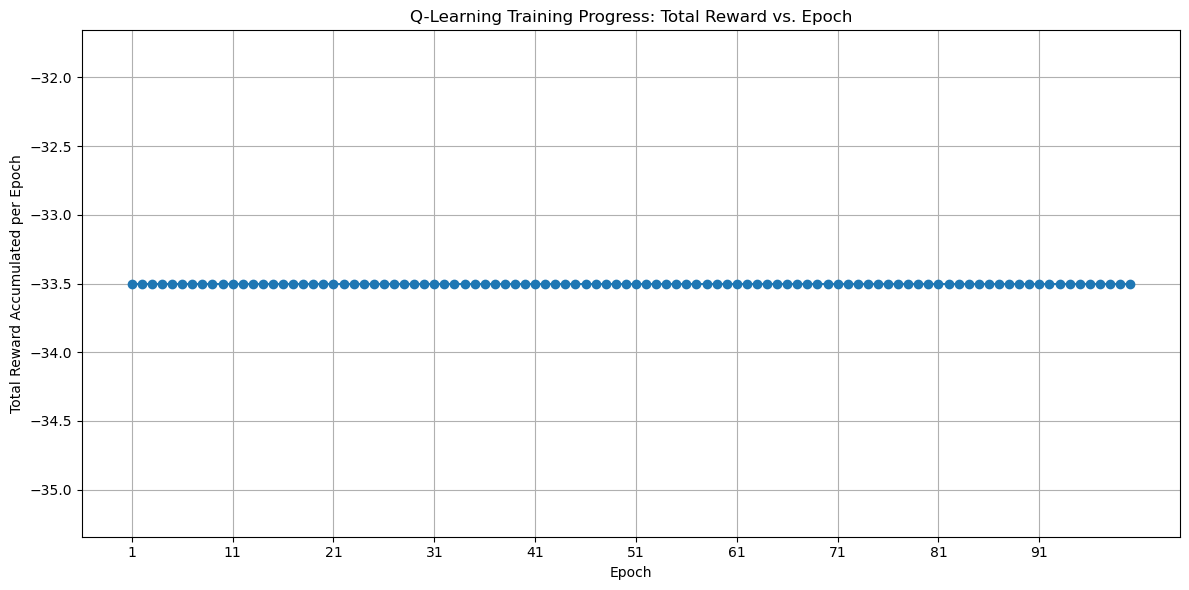

In [10]:
print(f"Learned Q-table contains {len(q_table)} states.")
print(f"Saving Q-table to {Q_TABLE_SAVE_PATH}...")
try:
    # Convert defaultdict back to dict for standard pickling
    with open(Q_TABLE_SAVE_PATH, 'wb') as f:
        pickle.dump(dict(q_table), f)
    print("Q-table saved successfully.")
except Exception as e:
    print(f"Error saving Q-table: {e}")

# --- Visualization ---
print("\nPlotting training progress...")
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, epoch_rewards_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Total Reward Accumulated per Epoch")
plt.title("Q-Learning Training Progress: Total Reward vs. Epoch")
plt.grid(True)
plt.xticks(np.arange(min(epochs), max(epochs)+1, step=max(1, NUM_EPOCHS // 10)))
plt.tight_layout()
plt.show() # Use plt.show()